In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_classif
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load the Boston housing dataset
df = pd.read_csv("/kaggle/input/the-boston-houseprice-data/boston.csv")

In [3]:
# Display basic information about the dataset
print("=== DATASET INFORMATION ===")
df.info()
print("\n=== DATASET STATISTICS ===")
print(df.describe())
print(f"\n=== DATA QUALITY CHECK ===")
print(f"Missing values: {df.isnull().sum().sum()}")
print(f"Duplicate rows: {df.duplicated().sum()}")

=== DATASET INFORMATION ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB

=== DATASET STATISTICS ===
             CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.613524

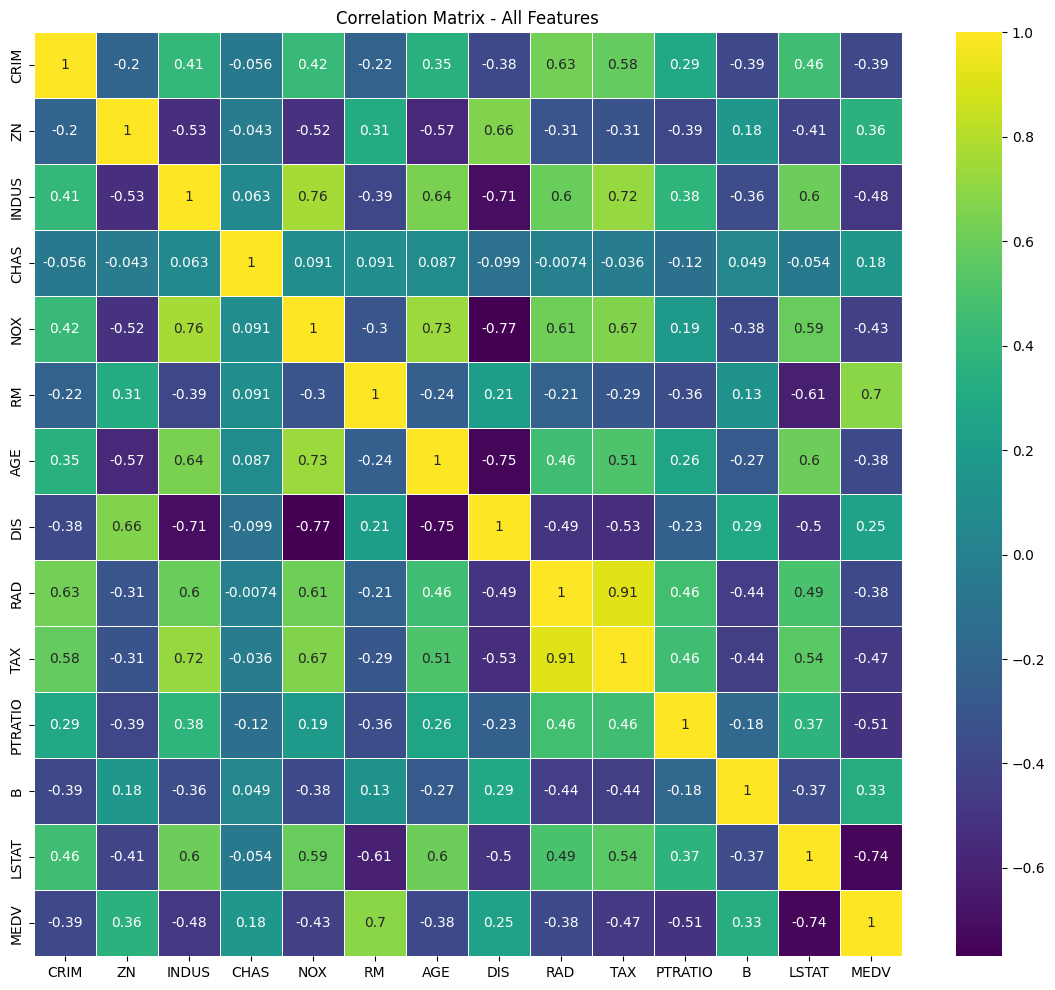

In [4]:
# Visualize correlation matrix of all features
plt.figure(figsize=(14, 12))
sns.heatmap(df.corr(), annot=True, cmap='viridis', linewidths=0.5)
plt.title("Correlation Matrix - All Features")
plt.show()

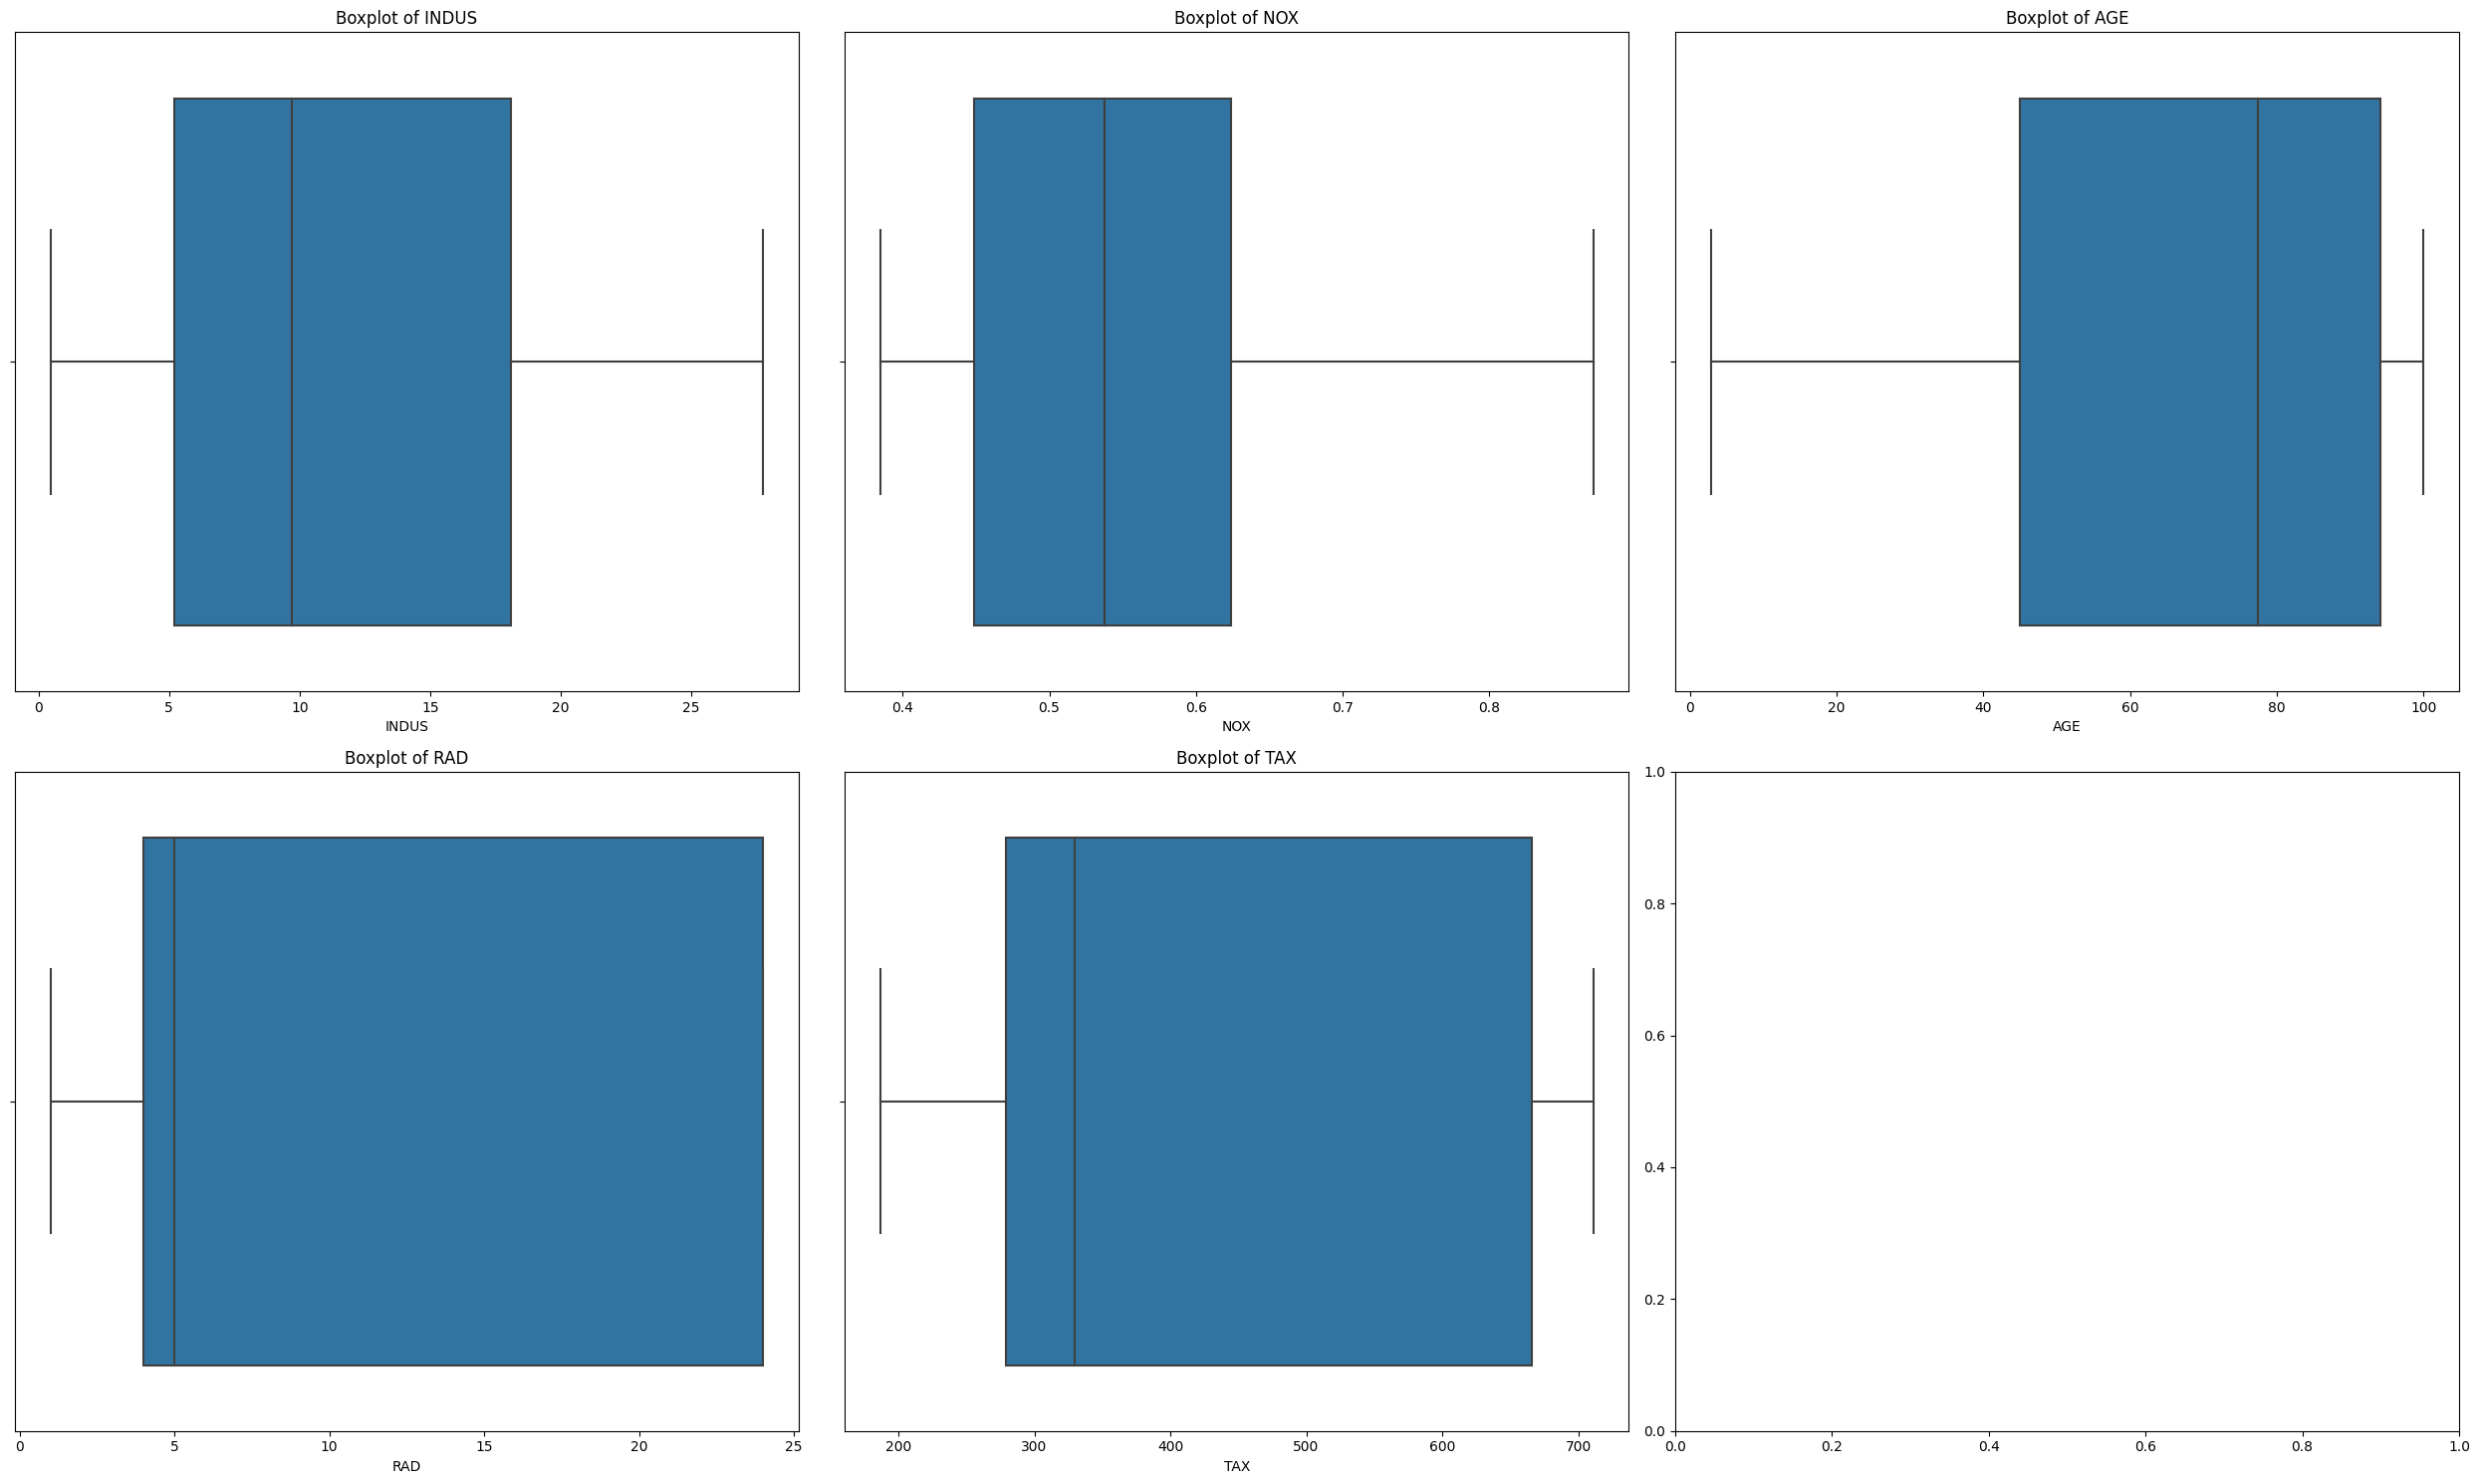

In [5]:
# Create boxplots for features with potential outliers
features_group1 = ['INDUS','NOX','AGE', 'RAD', 'TAX']
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25, 15))
for i, feature in enumerate(features_group1):
    row, col = divmod(i, 3)
    sns.boxplot(data=df, x=feature, ax=axes[row, col])
    axes[row, col].set_title(f'Boxplot of {feature}')
plt.tight_layout()
plt.show()

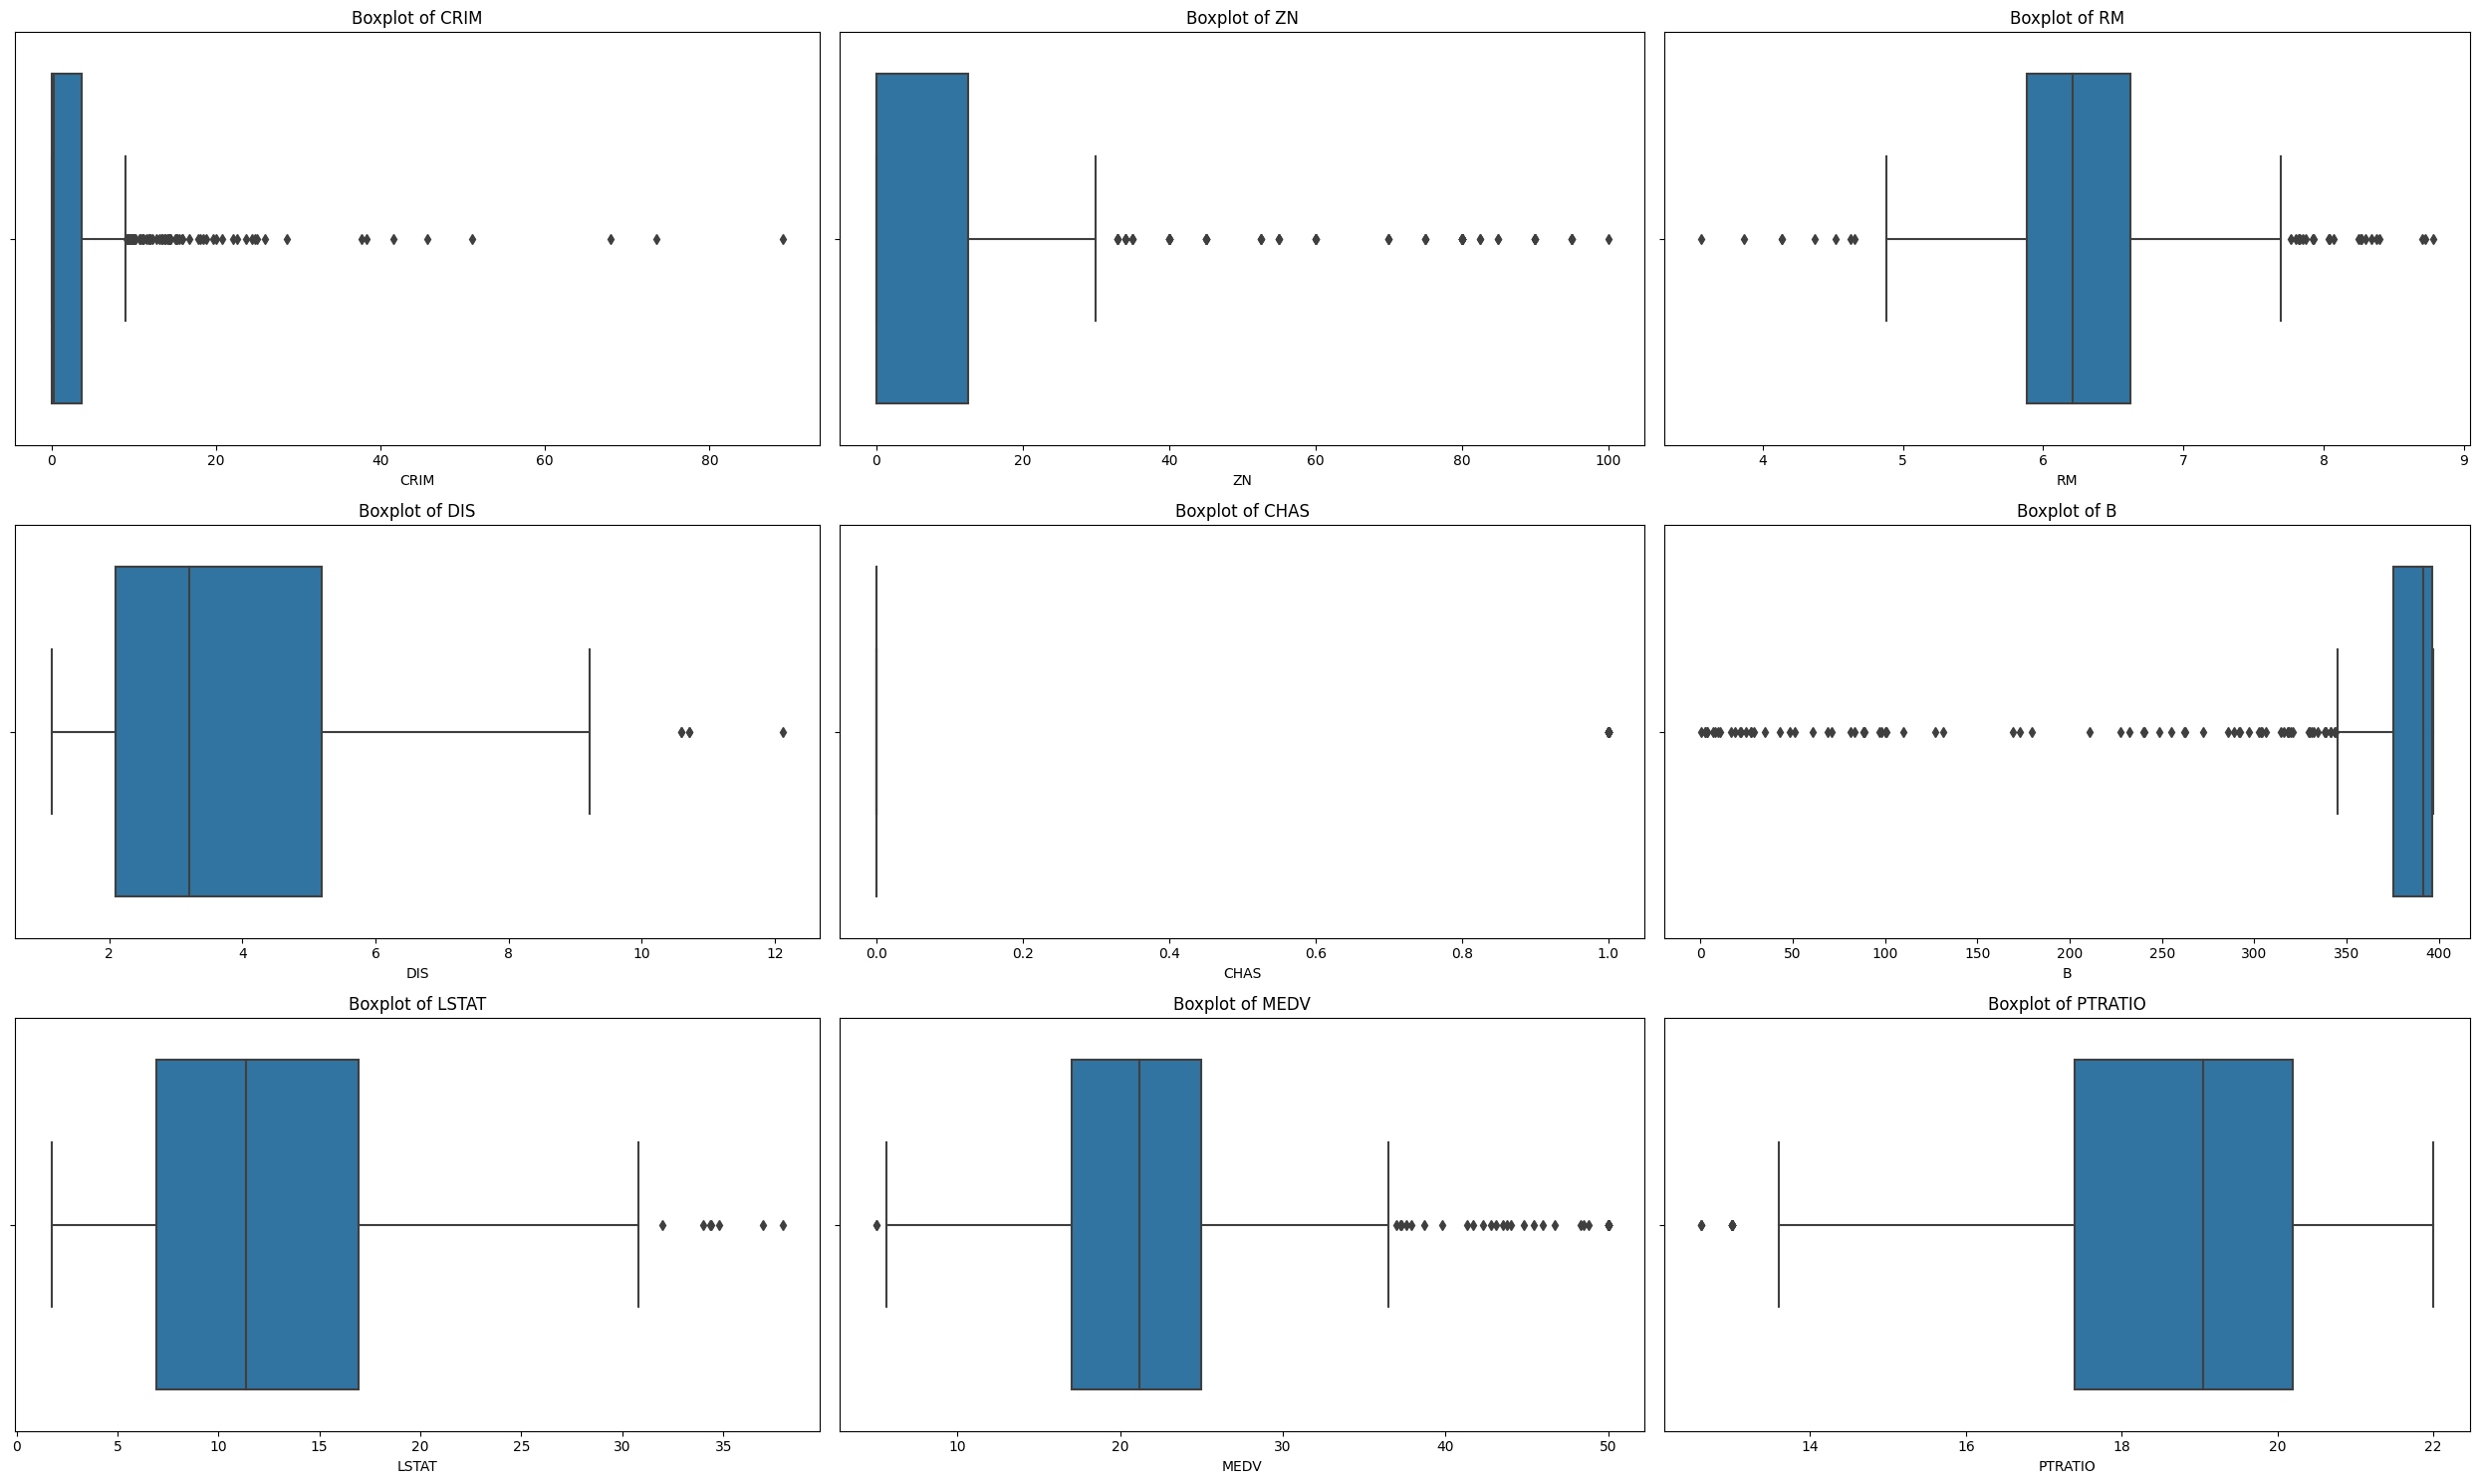

In [6]:
# Create boxplots for remaining features
features_group2 = ['CRIM','ZN','RM','DIS','CHAS','B','LSTAT','MEDV','PTRATIO']
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(25, 15))
for i, feature in enumerate(features_group2):
    row, col = divmod(i, 3)
    sns.boxplot(data=df, x=feature, ax=axes[row, col])
    axes[row, col].set_title(f'Boxplot of {feature}')
plt.tight_layout()
plt.show()

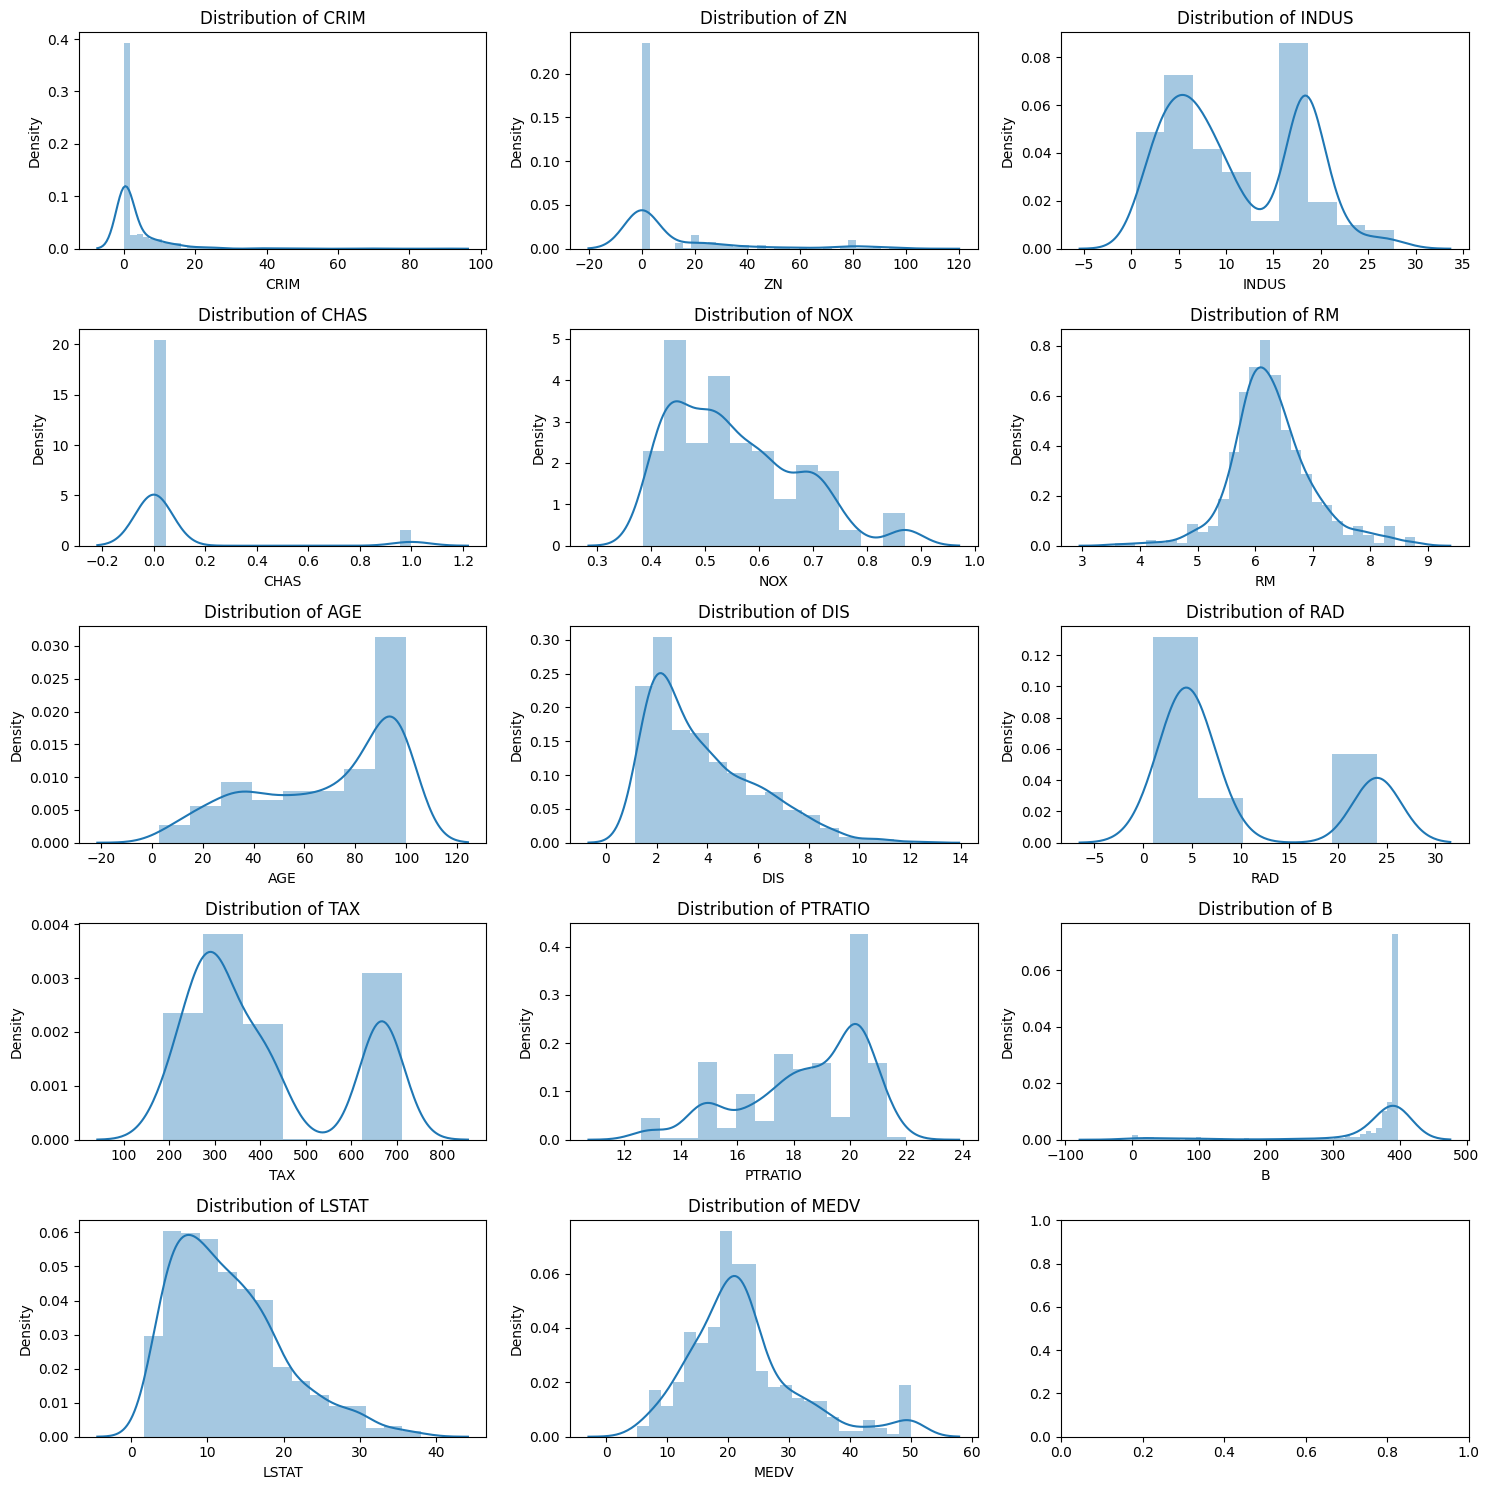

In [7]:
# Create distribution plots for all features
all_features = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 15))
for i, feature in enumerate(all_features):
    row, col = divmod(i, 3)
    sns.distplot(df[feature], ax=axes[row, col])
    axes[row, col].set_title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

=== OUTLIER REMOVAL METHOD ===


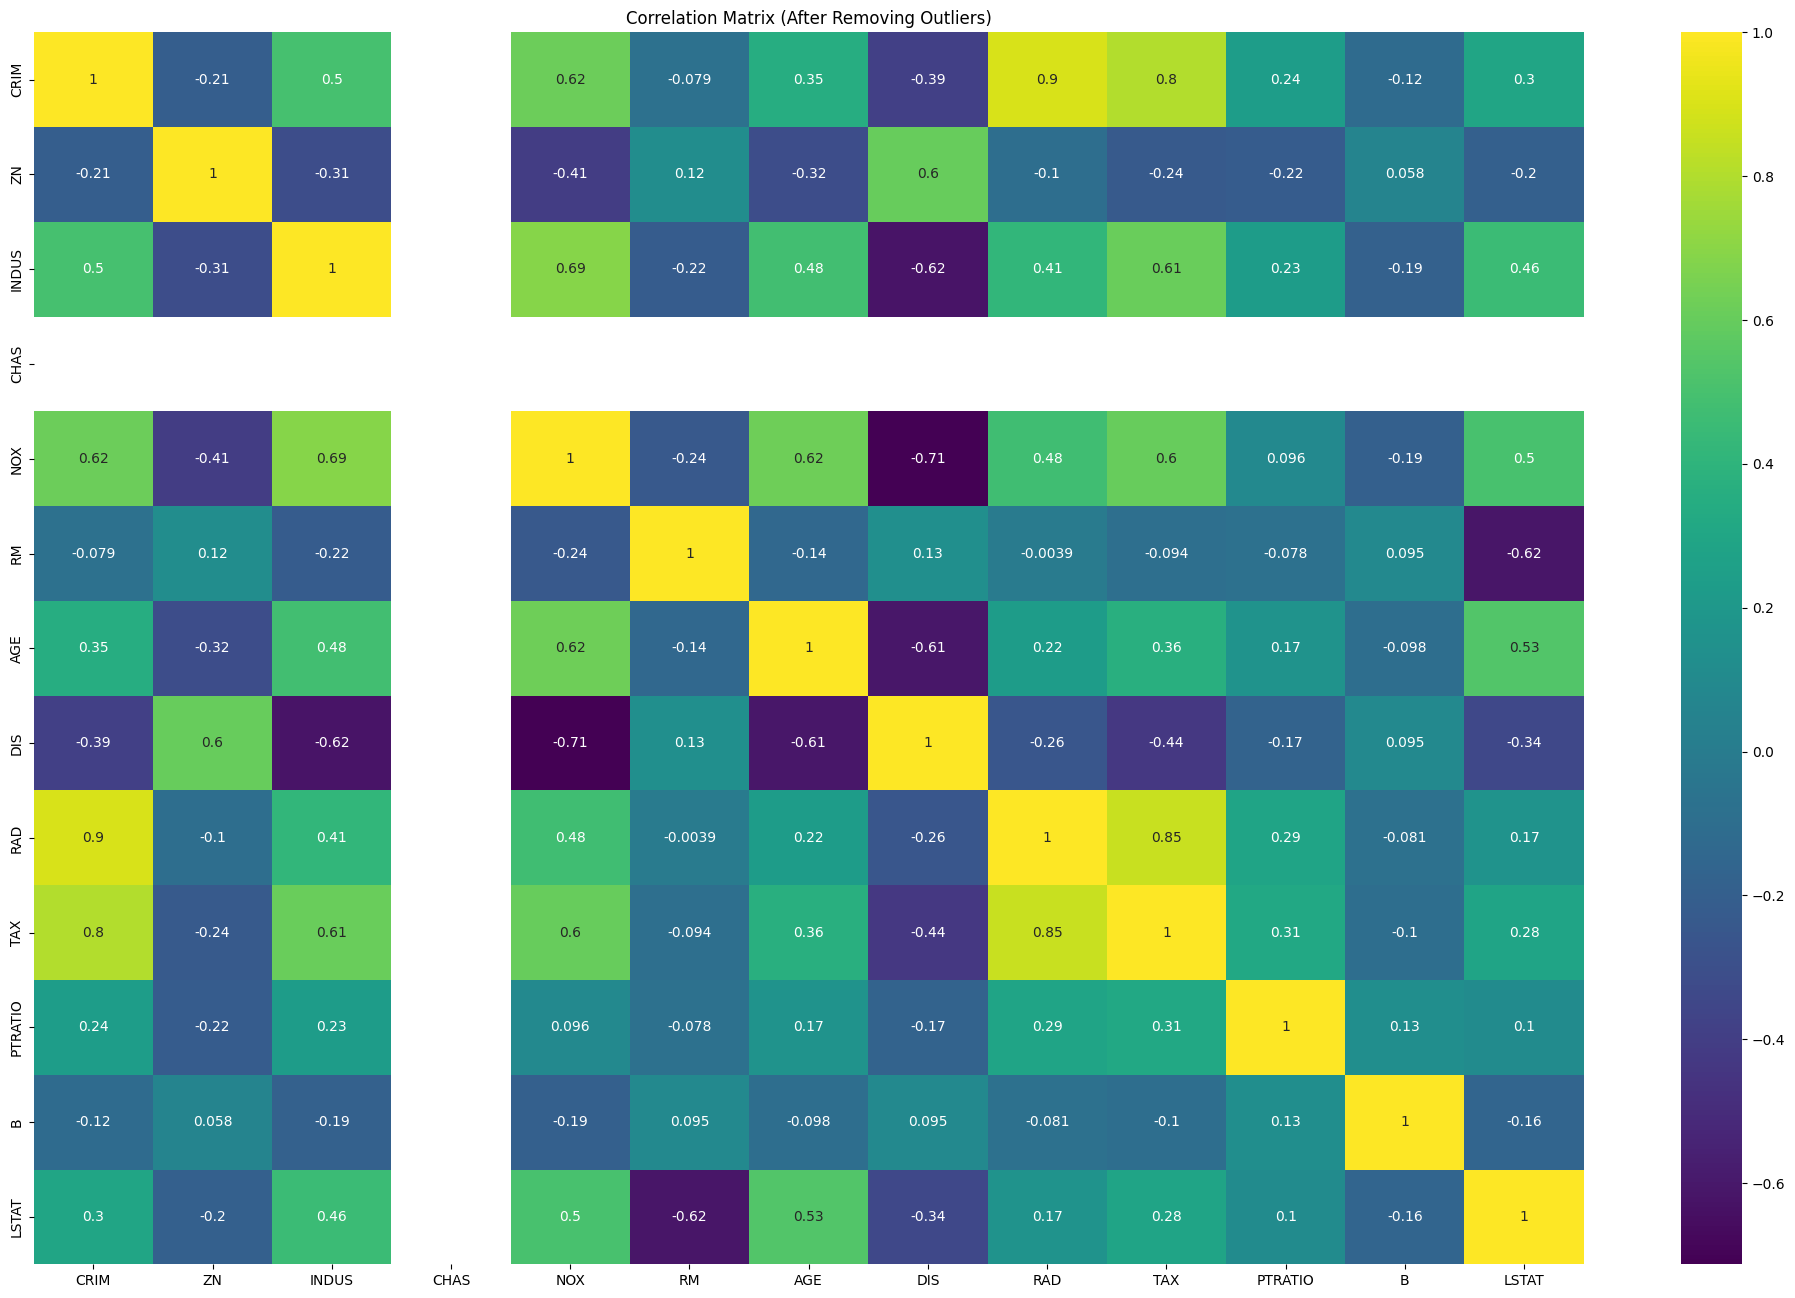

In [8]:
# Separate features and target variable
X = df.drop(["MEDV"], axis=1)
Y = df["MEDV"]

# Method 1: Remove outliers completely
print("=== OUTLIER REMOVAL METHOD ===")
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1
outliers_mask = ((X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR))).any(axis=1)
X_outliers_removed = X[~outliers_mask]
Y_outliers_removed = Y[~outliers_mask]

# Visualize correlation matrix after removing outliers
corr_matrix_removed = X_outliers_removed.corr()
plt.figure(figsize=(25, 16))
plt.title('Correlation Matrix (After Removing Outliers)')
sns.heatmap(corr_matrix_removed, annot=True, cmap='viridis')
plt.show()

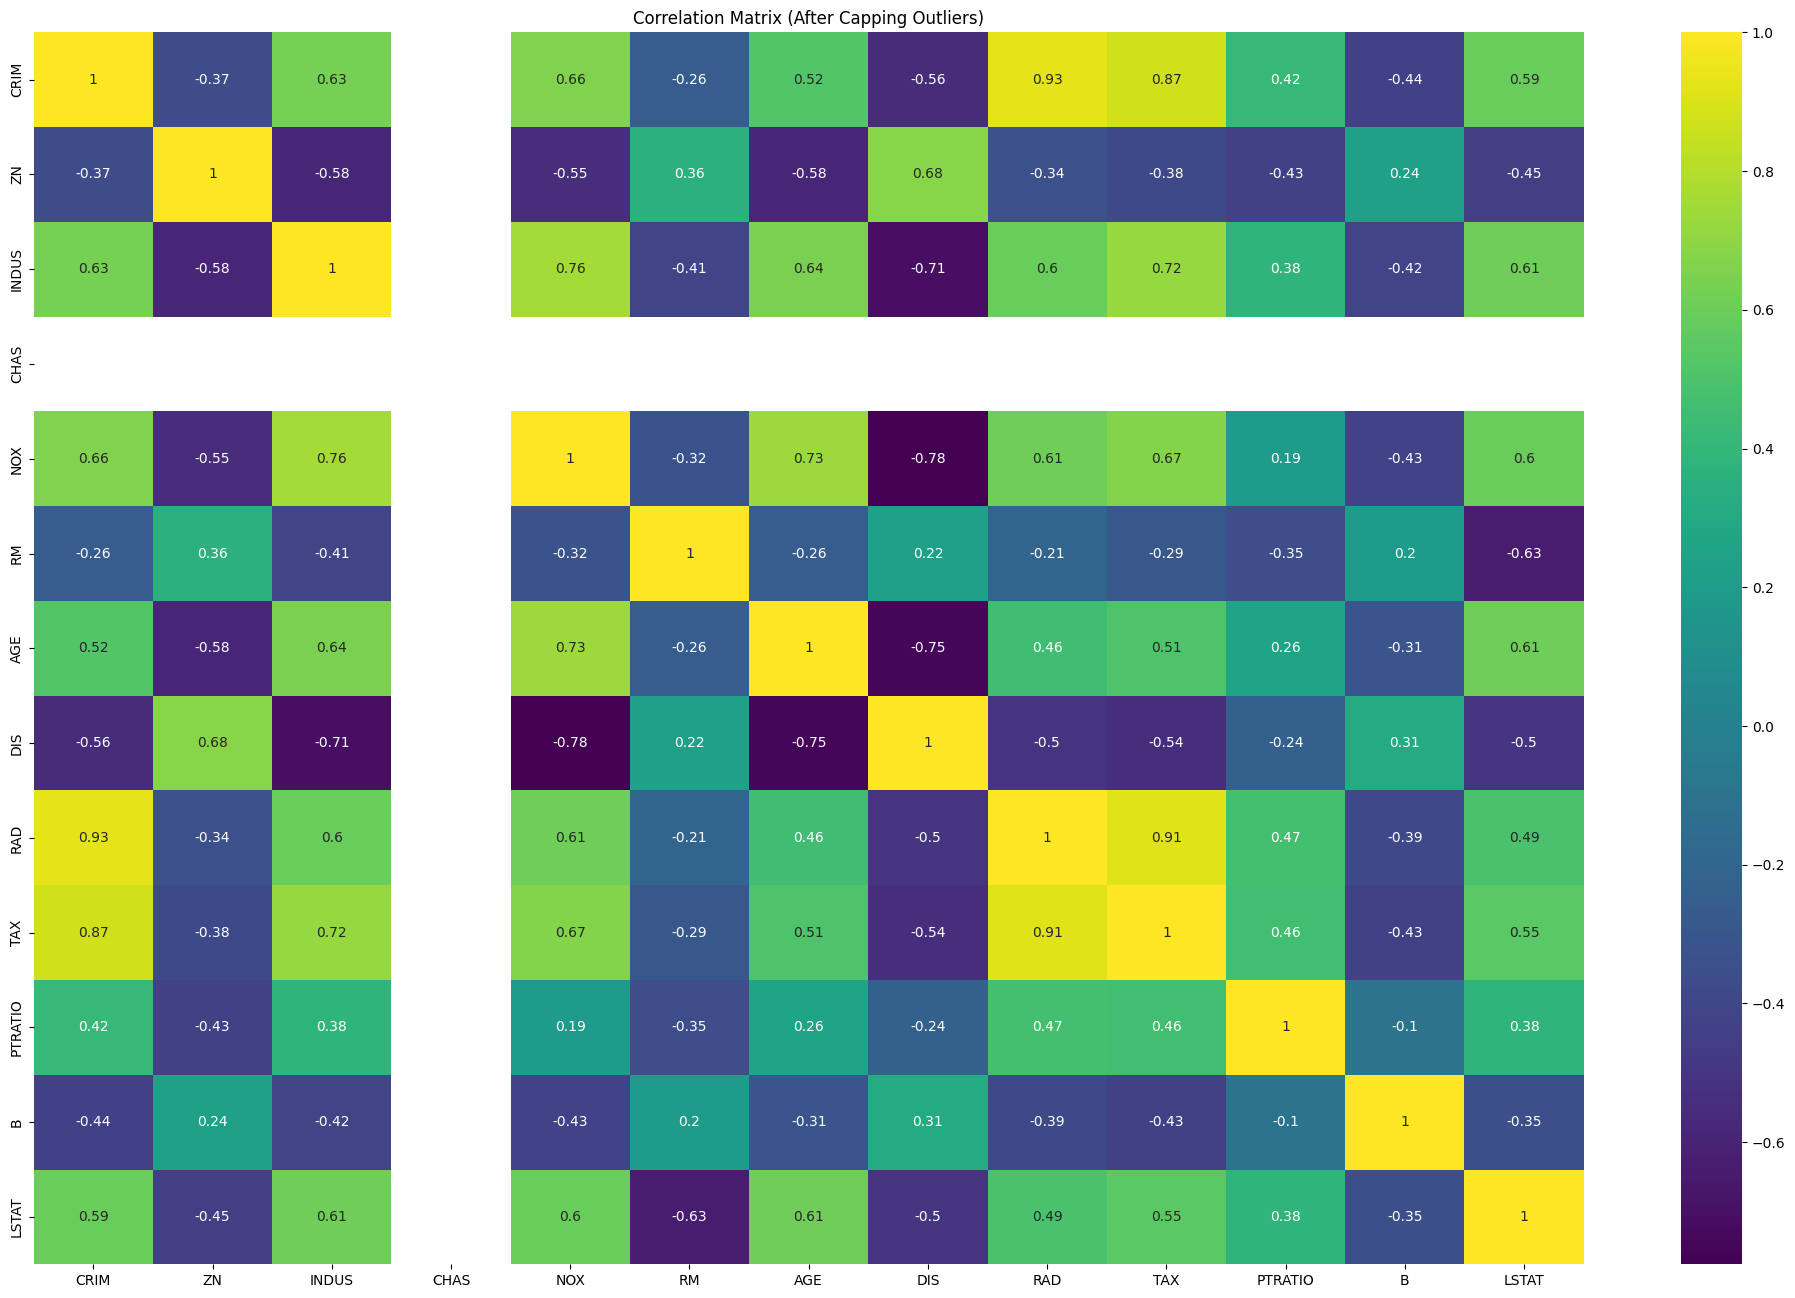

In [9]:
# Method 2: Merge outliers to boundary values (capping)
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
X_outliers_capped = X.copy()
for column in X.columns:
    X_outliers_capped[column] = np.where(X_outliers_capped[column] < lower_bound[column], 
                                        lower_bound[column], X_outliers_capped[column])
    X_outliers_capped[column] = np.where(X_outliers_capped[column] > upper_bound[column], 
                                        upper_bound[column], X_outliers_capped[column])

# Visualize correlation matrix after capping outliers
corr_matrix_capped = X_outliers_capped.corr()
plt.figure(figsize=(25, 16))
plt.title('Correlation Matrix (After Capping Outliers)')
sns.heatmap(corr_matrix_capped, annot=True, cmap='viridis')
plt.show()

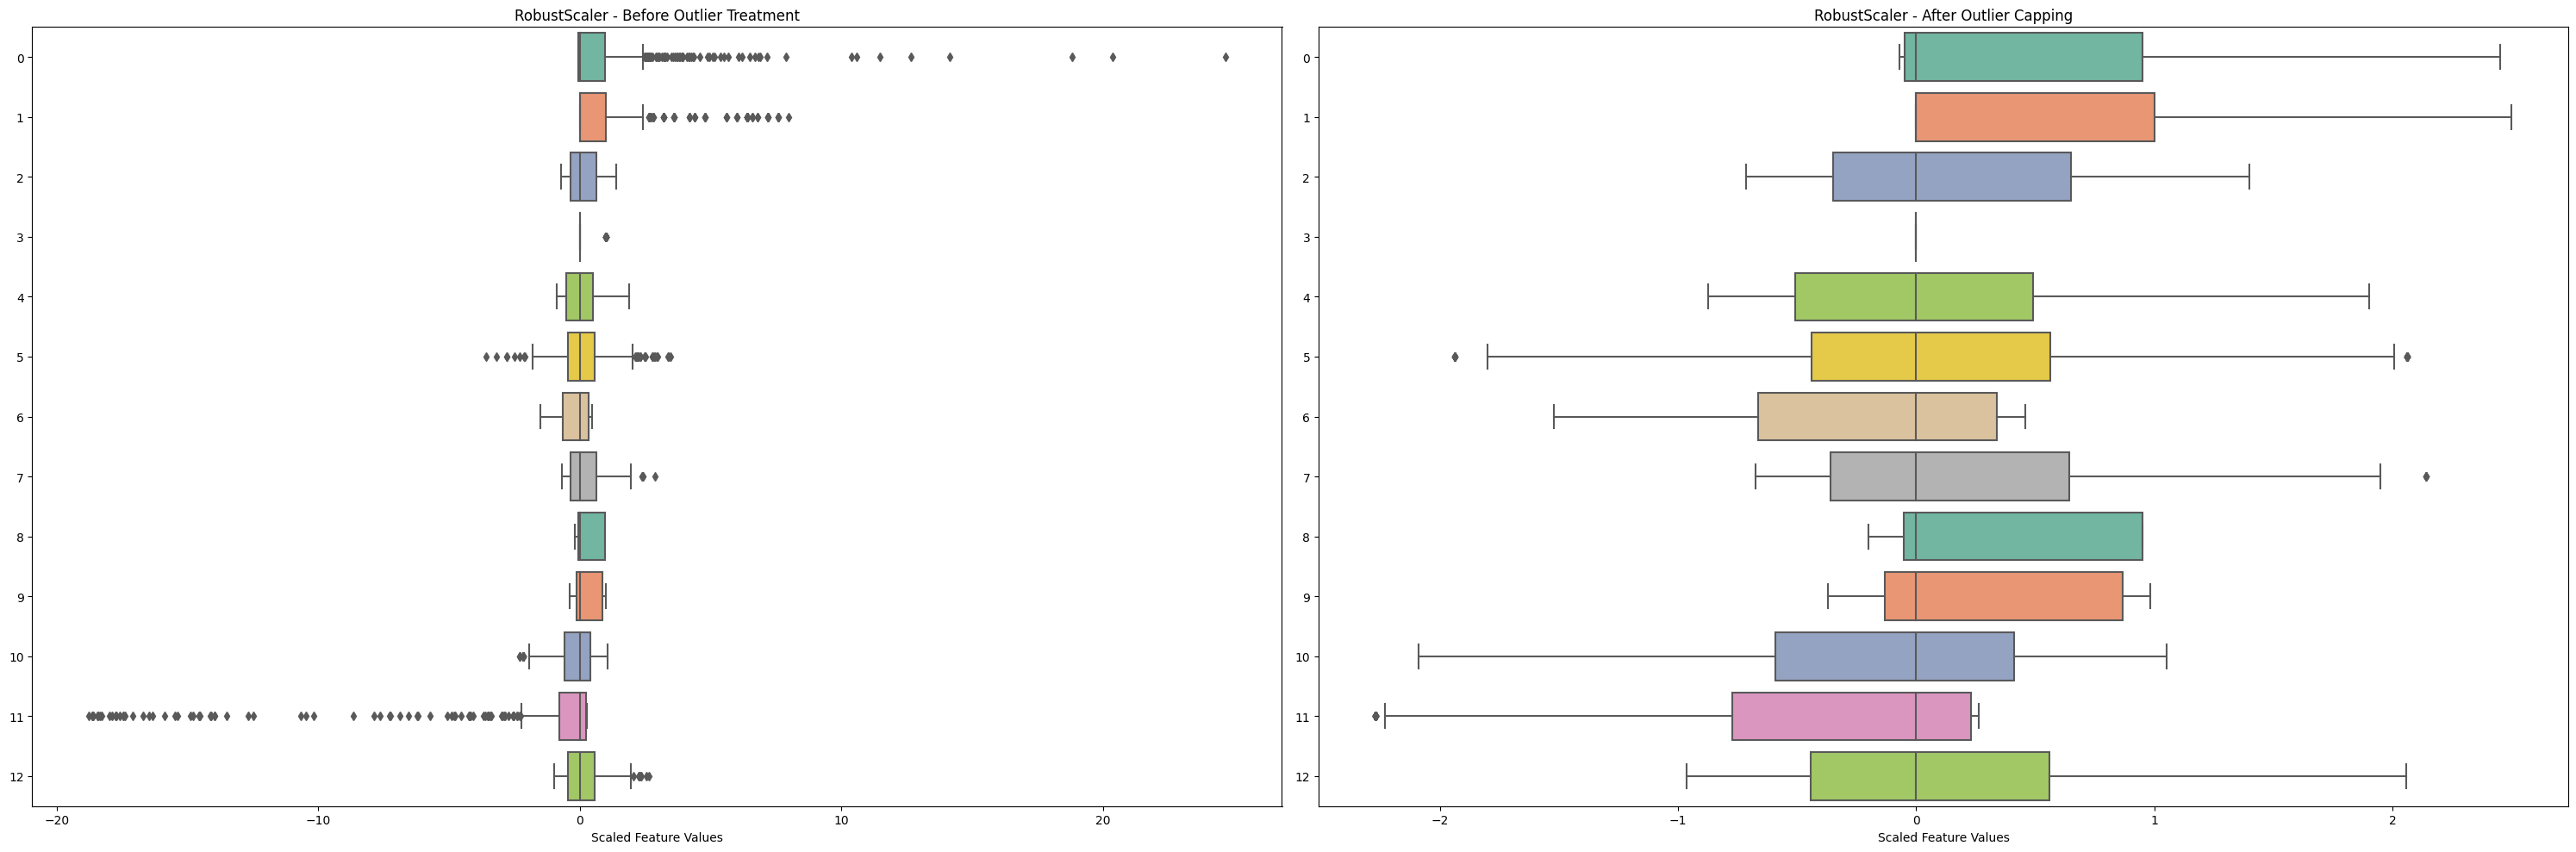

In [10]:
# RobustScaler comparison
scaler_robust = RobustScaler()
X_robust_original = scaler_robust.fit_transform(X)
X_robust_capped = RobustScaler().fit_transform(X_outliers_capped)

# Visualize RobustScaler results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10))
sns.boxplot(data=X_robust_original, orient="h", palette="Set2", ax=ax1)
ax1.set_title('RobustScaler - Before Outlier Treatment')
ax1.set_xlabel('Scaled Feature Values')

sns.boxplot(data=X_robust_capped, orient="h", palette="Set2", ax=ax2)
ax2.set_title('RobustScaler - After Outlier Capping')
ax2.set_xlabel('Scaled Feature Values')
plt.tight_layout()
plt.show()

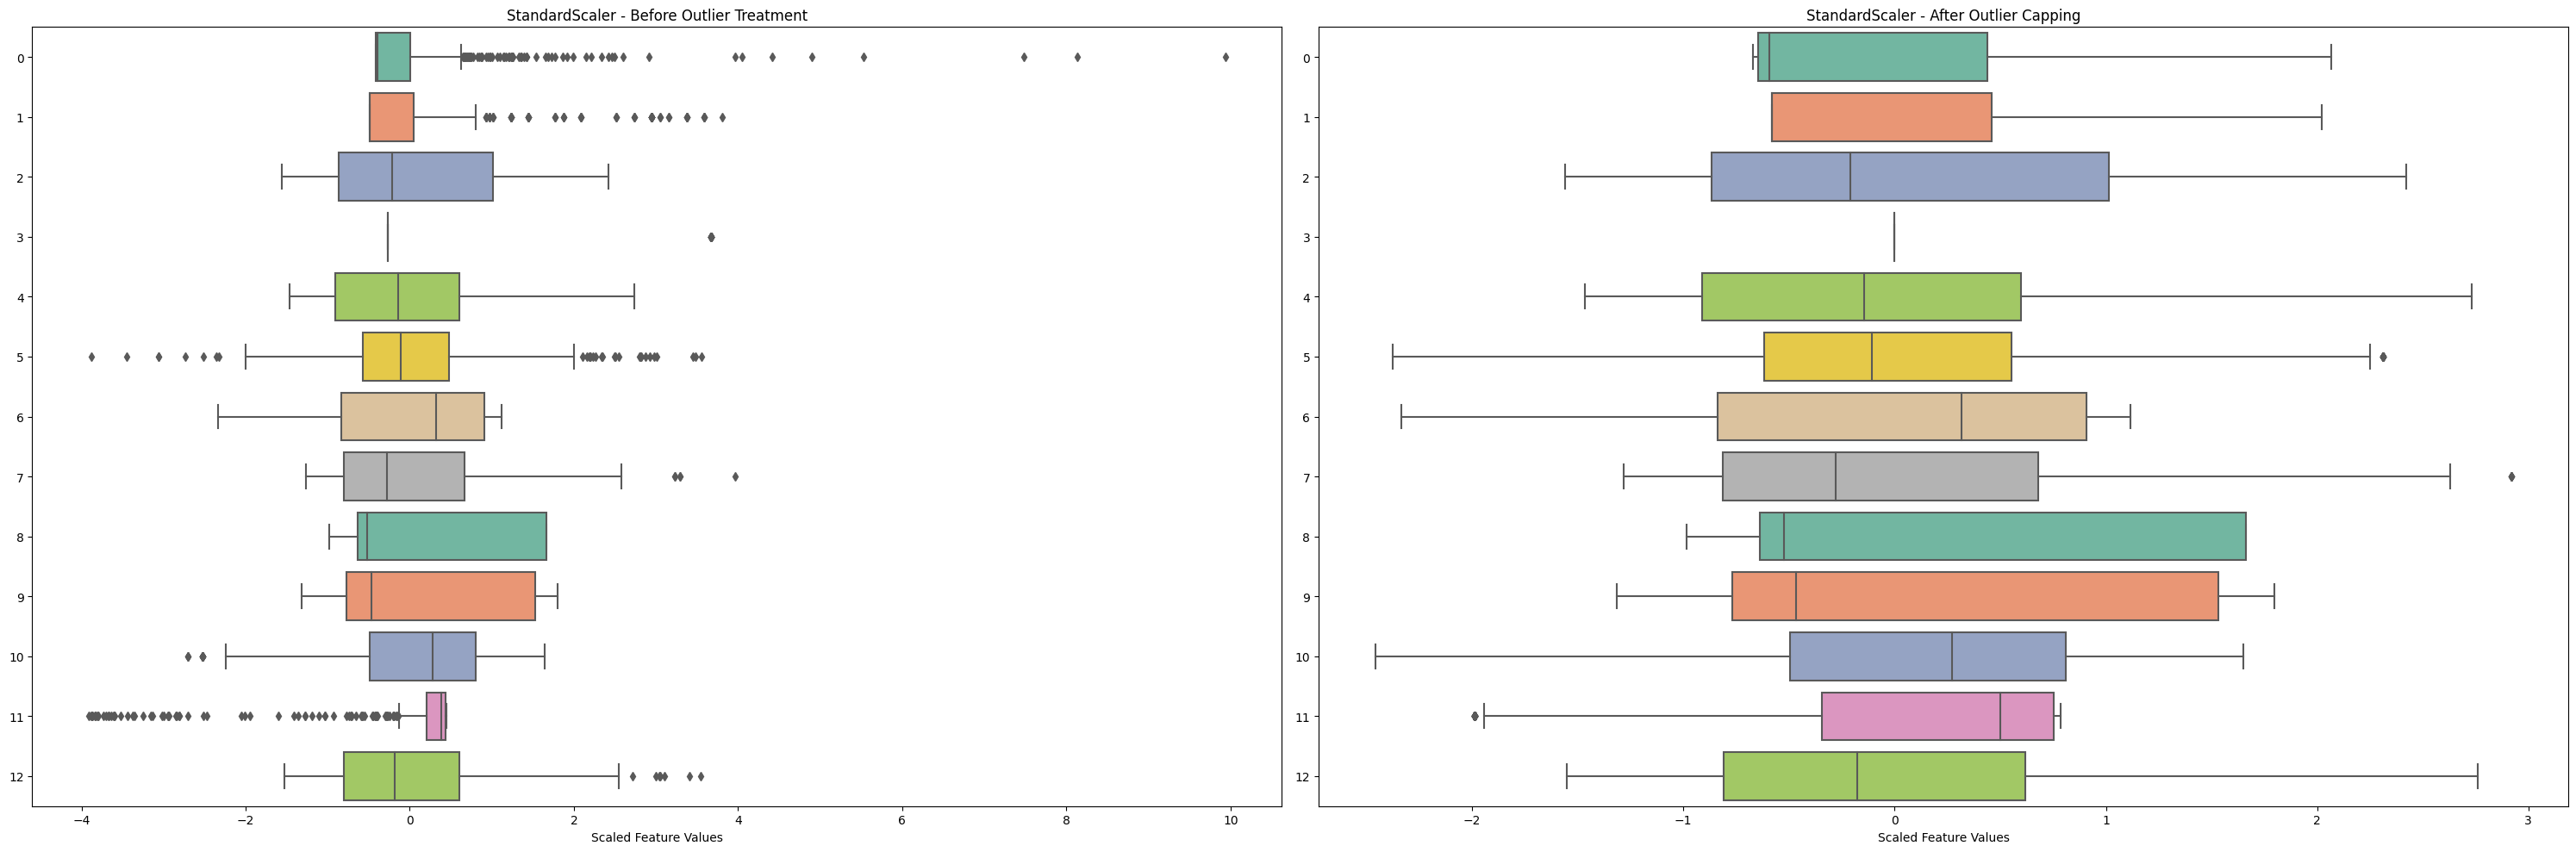

In [11]:
# StandardScaler comparison
scaler_standard = StandardScaler()
X_standard_original = scaler_standard.fit_transform(X)
X_standard_capped = StandardScaler().fit_transform(X_outliers_capped)

# Visualize StandardScaler results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10))
sns.boxplot(data=X_standard_original, orient="h", palette="Set2", ax=ax1)
ax1.set_title('StandardScaler - Before Outlier Treatment')
ax1.set_xlabel('Scaled Feature Values')

sns.boxplot(data=X_standard_capped, orient="h", palette="Set2", ax=ax2)
ax2.set_title('StandardScaler - After Outlier Capping')
ax2.set_xlabel('Scaled Feature Values')
plt.tight_layout()
plt.show()

In [12]:
# Select best 5 features from original data (excluding CHAS for classification)
X_for_selection = df.drop(["CHAS", "MEDV"], axis=1)
selector = SelectKBest(f_classif, k=5)
selector.fit(X_for_selection, Y)
selected_indices = selector.get_support(indices=True)
X_best_features = X_for_selection.iloc[:, selected_indices]

print(f"Selected features: {list(X_best_features.columns)}")

Selected features: ['CRIM', 'NOX', 'RM', 'AGE', 'LSTAT']


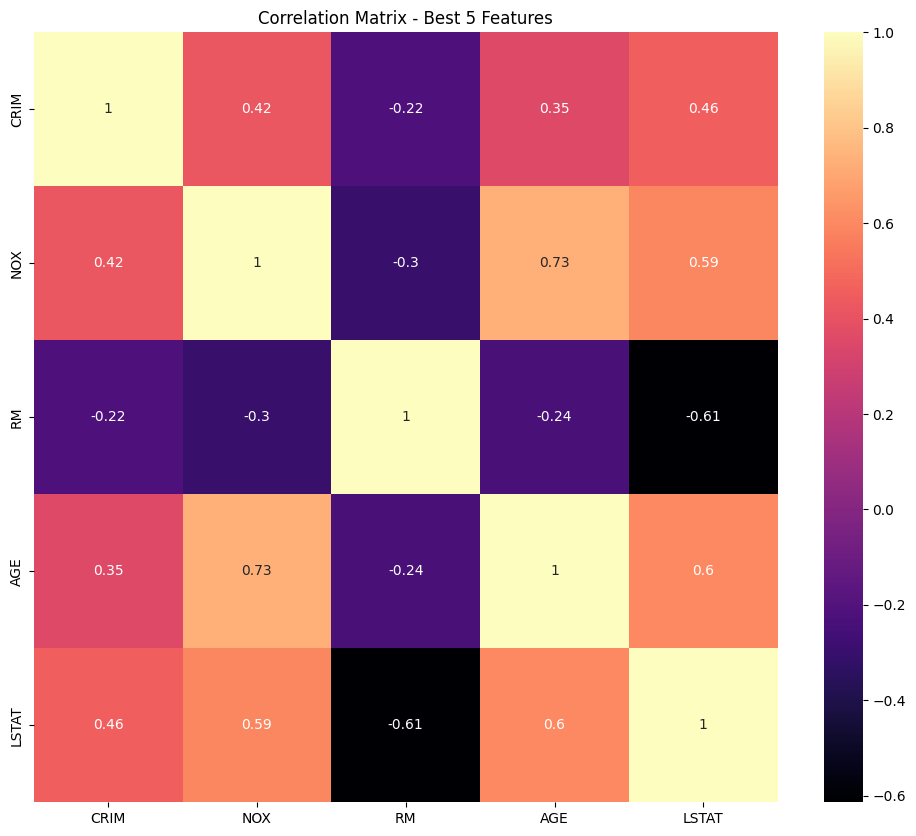

In [13]:
# Visualize correlation matrix of selected features
corr_matrix_best = X_best_features.corr()
plt.figure(figsize=(12, 10))
plt.title('Correlation Matrix - Best 5 Features')
sns.heatmap(corr_matrix_best, annot=True, cmap='magma')
plt.show()

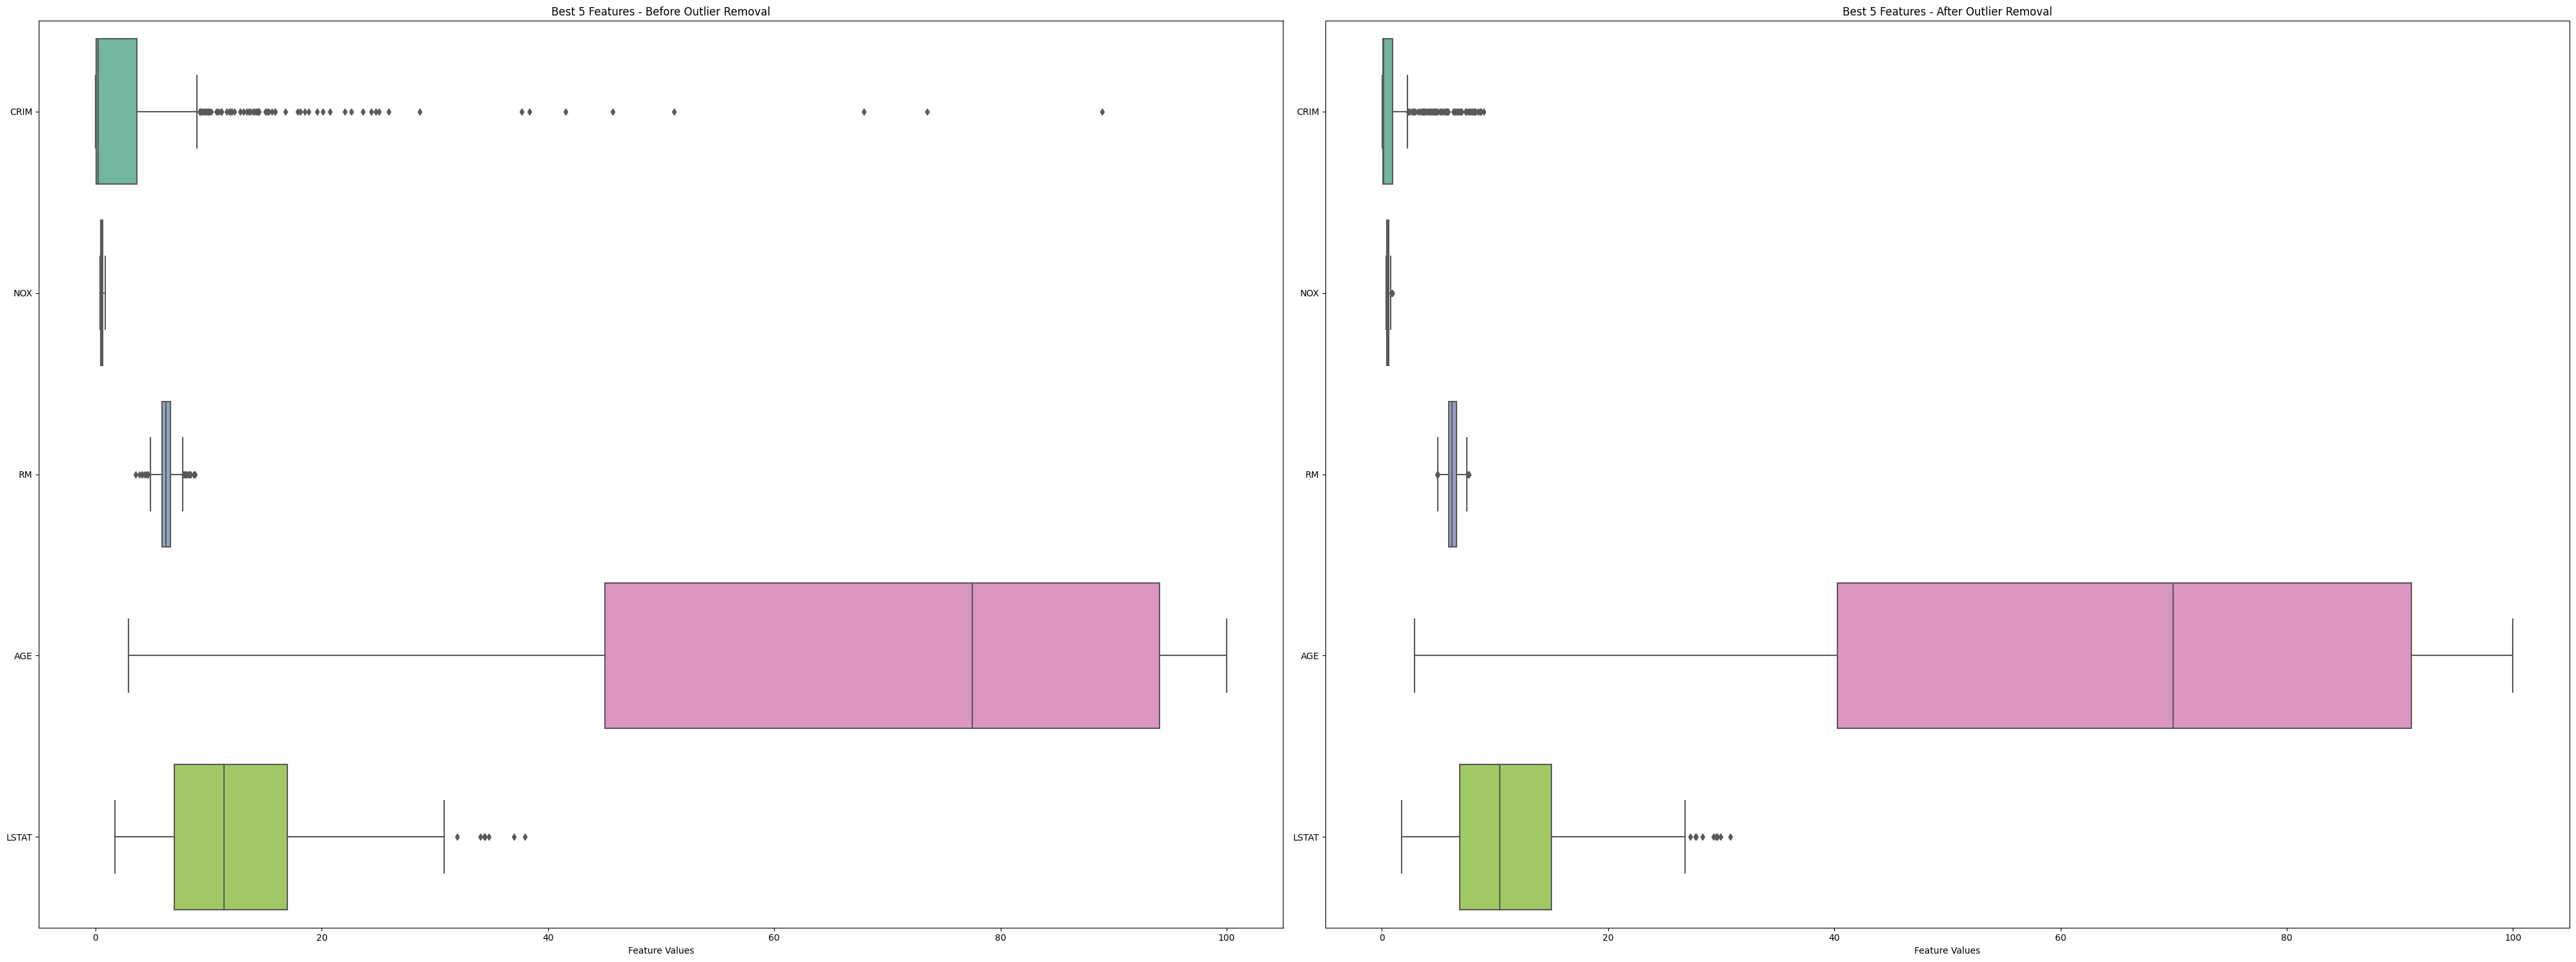

In [14]:
# Apply outlier removal to selected features
Q1_best = X_best_features.quantile(0.25)
Q3_best = X_best_features.quantile(0.75)
IQR_best = Q3_best - Q1_best
outliers_mask_best = ((X_best_features < (Q1_best - 1.5 * IQR_best)) | 
                      (X_best_features > (Q3_best + 1.5 * IQR_best))).any(axis=1)
X_best_cleaned = X_best_features[~outliers_mask_best]
Y_best_cleaned = Y[~outliers_mask_best]

# Visualize boxplots for best features before and after cleaning
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(40, 15))
sns.boxplot(data=X_best_features, orient="h", palette="Set2", ax=ax1)
ax1.set_title('Best 5 Features - Before Outlier Removal')
ax1.set_xlabel('Feature Values')

sns.boxplot(data=X_best_cleaned, orient="h", palette="Set2", ax=ax2)
ax2.set_title('Best 5 Features - After Outlier Removal')
ax2.set_xlabel('Feature Values')
plt.tight_layout()
plt.show()

In [15]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """Evaluate model performance and print results"""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{model_name} - MSE: {mse:.4f}, R2: {r2:.4f}")
    return mse, r2

In [16]:
# Prepare different datasets for comparison
datasets = {
    "Original Data": (X, Y),
    "Scaled Capped Data": (X_robust_capped, Y),
    "Best 5 Features": (X_best_features, Y),
    "Best 5 Features Cleaned": (X_best_cleaned, Y_best_cleaned)
}

# Compare models across different datasets
models = {
    "Linear Regression": LinearRegression(),
    "SVR (Linear)": SVR(kernel='linear'),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42)
}

results = {}
for dataset_name, (X_data, Y_data) in datasets.items():
    print(f"\n--- {dataset_name} ---")
    X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.3, random_state=42)
    
    dataset_results = {}
    for model_name, model in models.items():
        mse, r2 = evaluate_model(model, X_train, X_test, y_train, y_test, model_name)
        dataset_results[model_name] = {"MSE": mse, "R2": r2}
    
    results[dataset_name] = dataset_results


--- Original Data ---
Linear Regression - MSE: 21.5174, R2: 0.7112
SVR (Linear) - MSE: 25.6264, R2: 0.6561
Random Forest - MSE: 9.6197, R2: 0.8709

--- Scaled Capped Data ---
Linear Regression - MSE: 21.6313, R2: 0.7097
SVR (Linear) - MSE: 24.6025, R2: 0.6698
Random Forest - MSE: 10.0195, R2: 0.8655

--- Best 5 Features ---
Linear Regression - MSE: 30.2193, R2: 0.5944
SVR (Linear) - MSE: 30.6440, R2: 0.5887
Random Forest - MSE: 11.7182, R2: 0.8427

--- Best 5 Features Cleaned ---
Linear Regression - MSE: 20.0820, R2: 0.5461
SVR (Linear) - MSE: 19.1542, R2: 0.5670
Random Forest - MSE: 16.0252, R2: 0.6378


In [17]:
# Use original data for hyperparameter tuning
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [18]:
# Ridge Regression with GridSearchCV
param_grid_ridge = {'alpha': [0.01, 0.1, 1, 10, 100]}
ridge_grid = GridSearchCV(Ridge(), param_grid_ridge, cv=5, scoring='neg_mean_squared_error')
ridge_grid.fit(X_train, y_train)

best_ridge = ridge_grid.best_estimator_
ridge_cv_scores = cross_val_score(best_ridge, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
ridge_cv_mse = -ridge_cv_scores.mean()
ridge_cv_r2 = cross_val_score(best_ridge, X_train, y_train, cv=5, scoring='r2').mean()

y_pred_ridge = best_ridge.predict(X_test)
ridge_test_mse = mean_squared_error(y_test, y_pred_ridge)
ridge_test_r2 = r2_score(y_test, y_pred_ridge)

print(f"Best Alpha: {ridge_grid.best_params_['alpha']}")
print(f"CV MSE: {ridge_cv_mse:.4f}, CV R2: {ridge_cv_r2:.4f}")
print(f"Test MSE: {ridge_test_mse:.4f}, Test R2: {ridge_test_r2:.4f}")

Best Alpha: 0.01
CV MSE: 25.9787, CV R2: 0.6880
Test MSE: 21.5242, Test R2: 0.7111


In [19]:
# Lasso Regression with manual cross-validation
alphas = [0.01, 0.1, 1, 10, 100]
best_alpha_lasso = None
best_mse_lasso = float('inf')

for alpha in alphas:
    lasso_model = Lasso(alpha=alpha)
    mse_scores = -cross_val_score(lasso_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    avg_mse = mse_scores.mean()
    
    if avg_mse < best_mse_lasso:
        best_mse_lasso = avg_mse
        best_alpha_lasso = alpha

best_lasso = Lasso(alpha=best_alpha_lasso)
best_lasso.fit(X_train, y_train)

lasso_cv_scores = cross_val_score(best_lasso, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
lasso_cv_mse = -lasso_cv_scores.mean()
lasso_cv_r2 = cross_val_score(best_lasso, X_train, y_train, cv=5, scoring='r2').mean()

y_pred_lasso = best_lasso.predict(X_test)
lasso_test_mse = mean_squared_error(y_test, y_pred_lasso)
lasso_test_r2 = r2_score(y_test, y_pred_lasso)

print(f"Best Alpha: {best_alpha_lasso}")
print(f"CV MSE: {lasso_cv_mse:.4f}, CV R2: {lasso_cv_r2:.4f}")
print(f"Test MSE: {lasso_test_mse:.4f}, Test R2: {lasso_test_r2:.4f}")

Best Alpha: 0.01
CV MSE: 26.0486, CV R2: 0.6874
Test MSE: 21.6962, Test R2: 0.7088


In [22]:
# Random Forest with comprehensive grid search
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [1.0, 'sqrt', 'log2']
}

rf_grid = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_rf, 
                       cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
rf_grid.fit(X_train, y_train)

best_rf = rf_grid.best_estimator_
rf_cv_scores = cross_val_score(best_rf, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
rf_cv_mse = -rf_cv_scores.mean()
rf_cv_r2 = cross_val_score(best_rf, X_train, y_train, cv=5, scoring='r2').mean()

y_pred_rf = best_rf.predict(X_test)
rf_test_mse = mean_squared_error(y_test, y_pred_rf)
rf_test_r2 = r2_score(y_test, y_pred_rf)

print(f"Best Parameters: {rf_grid.best_params_}")
print(f"CV MSE: {rf_cv_mse:.4f}, CV R2: {rf_cv_r2:.4f}")
print(f"Test MSE: {rf_test_mse:.4f}, Test R2: {rf_test_r2:.4f}")

Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
CV MSE: 14.2299, CV R2: 0.8312
Test MSE: 10.6715, Test R2: 0.8568


In [23]:
final_results = {
    "Ridge (Tuned)": {"CV_MSE": ridge_cv_mse, "CV_R2": ridge_cv_r2, "Test_MSE": ridge_test_mse, "Test_R2": ridge_test_r2},
    "Lasso (Tuned)": {"CV_MSE": lasso_cv_mse, "CV_R2": lasso_cv_r2, "Test_MSE": lasso_test_mse, "Test_R2": lasso_test_r2},
    "Random Forest (Tuned)": {"CV_MSE": rf_cv_mse, "CV_R2": rf_cv_r2, "Test_MSE": rf_test_mse, "Test_R2": rf_test_r2}
}

for model_name, metrics in final_results.items():
    print(f"{model_name}:")
    print(f"  Cross-Validation - MSE: {metrics['CV_MSE']:.4f}, R2: {metrics['CV_R2']:.4f}")
    print(f"  Test Set - MSE: {metrics['Test_MSE']:.4f}, R2: {metrics['Test_R2']:.4f}")
    print()

Ridge (Tuned):
  Cross-Validation - MSE: 25.9787, R2: 0.6880
  Test Set - MSE: 21.5242, R2: 0.7111

Lasso (Tuned):
  Cross-Validation - MSE: 26.0486, R2: 0.6874
  Test Set - MSE: 21.6962, R2: 0.7088

Random Forest (Tuned):
  Cross-Validation - MSE: 14.2299, R2: 0.8312
  Test Set - MSE: 10.6715, R2: 0.8568

